In [1]:
%reload_ext autoreload
%autoreload 2

import os, psutil

os.environ['NUMEXPR_MAX_THREADS'] = '20'
from alphadia.extraction import processlogger
processlogger.init_logging()
import logging

logger = logging.getLogger()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neptune.new as neptune

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
#from alphabase.spectral_library.reader import LibraryReaderBase

from alphadia.extraction.data import TimsTOFDIA
from alphadia.extraction.planning import Plan, Workflow
from alphadia.extraction.calibration import RunCalibration
from alphadia.extraction.candidateselection import MS1CentricCandidateSelection
from alphadia.extraction.scoring import fdr_correction, MS2ExtractionWorkflow
import alphadia.extraction.utils as utils
yaml_file = 'config.yaml'

raw_files = ['/Users/georgwallmann/Documents/data/alphadia_benchmarking/raw_data/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_diaPASEF_S4-A1_1_500.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_diaPASEF_S4-A2_1_504.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_diaPASEF_S4-A3_1_508.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_diaPASEF_S4-A4_1_512.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A1_1_449.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A2_1_453.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A3_1_457.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A4_1_464.d'

             ]

output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_02_27_diaPASEF_vs_synchroPASEF_hybrid/hela_48_fractions'

try:
    neptune_token = os.environ['NEPTUNE_TOKEN']
except KeyError:
    logger.error('NEPTUNE_TOKEN environtment variable not set')


0:00:02.749440  WARNING: WARNING: Temp mmap arrays are written to /var/folders/lc/9594t94d5b5_gn0y04w1jh980000gn/T/temp_mmap_qgl8kgfi. Cleanup of this folder is OS dependant, and might need to be triggered manually! Current space: 1,241,058,058,240
0:00:02.750067  WARNING: WARNING: No Bruker libraries are available for this operating system. Mobility and m/z values need to be estimated. While this estimation often returns acceptable results with errors < 0.02 Th, huge errors (e.g. offsets of 6 Th) have already been observed for some samples!
0:00:02.750332  INFO: 
0:00:04.624746  ERROR: NEPTUNE_TOKEN environtment variable not set


In [2]:
import warnings

def fragment_number(precursor_df, fragment_intensity_df) :
    if not set(['frag_start_idx', 'frag_stop_idx']).issubset(precursor_df.columns):
        warnings.warn('frag_start_idx and frag_stop_idx not in dataframe')
        return
    
    n_fragments = []
    
    for start, stop in zip(precursor_df['frag_start_idx'].values, precursor_df['frag_stop_idx'].values):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df['n_fragments'] = n_fragments

In [3]:
test_lib = SpecLibBase()
test_lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2_predicted_after_merge_head.hdf'
test_lib.load_hdf(test_lib_location, load_mod_seq=True)

#test_lib.precursor_df.drop(columns=['rt'], inplace=True)

#test_lib.precursor_df = test_lib.precursor_df[test_lib.precursor_df['rt_norm'] > -0.5]

# scale rt_norm to from min max to 0-1
#test_lib.precursor_df['rt_norm'] = (test_lib.precursor_df['rt_norm'] - test_lib.precursor_df['rt_norm'].min())/(test_lib.precursor_df['rt_norm'].max() - test_lib.precursor_df['rt_norm'].min())

In [4]:
fragment_number(test_lib.precursor_df, test_lib.fragment_intensity_df)

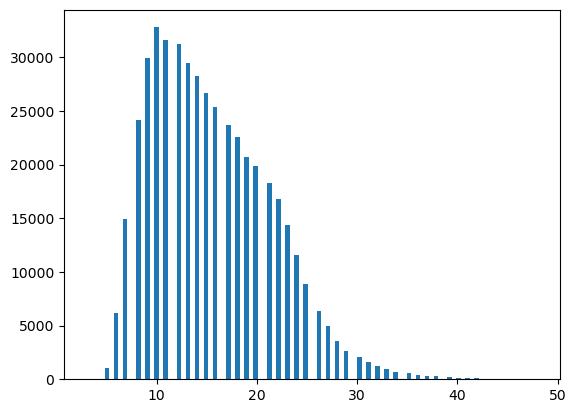

In [5]:
_ = plt.hist(test_lib.precursor_df['n_fragments'], bins=100)

In [6]:
test_lib.precursor_df['elution_group_idx'] = np.arange(len(test_lib.precursor_df))

0:00:14.095655  PROGRESS:       _   _      _         ___ ___   _   
0:00:14.096219  PROGRESS:      /_\ | |_ __| |_  __ _|   \_ _| /_\  
0:00:14.096599  PROGRESS:     / _ \| | '_ \ ' \/ _` | |) | | / _ \ 
0:00:14.096920  PROGRESS:    /_/ \_\_| .__/_||_\__,_|___/___/_/ \_\
0:00:14.097162  PROGRESS:            |_|                            
0:00:14.097433  PROGRESS: 
0:00:14.097916  INFO: loading default config from /Users/georgwallmann/Documents/git/alphadia/alphadia/extraction/../../misc/config/default.yaml
0:00:14.103327  PROGRESS: version: 1.0.1
0:00:14.103787  PROGRESS: hostname: Georgs-MacBook-Pro.local
0:00:14.104120  PROGRESS: date: 2023-03-06 20:50:19
0:00:20.023045  INFO: renaming precursor_columns columns
0:00:20.023994  INFO: renaming fragment_columns columns
0:00:20.024414  INFO: ========= Library Stats =========
0:00:20.024668  INFO: Number of precursors: 464,663
0:00:20.086547  INFO: 	thereof targets:234,993
0:00:20.086994  INFO: 	thereof decoys: 229,670
0:00:20.091417  IN

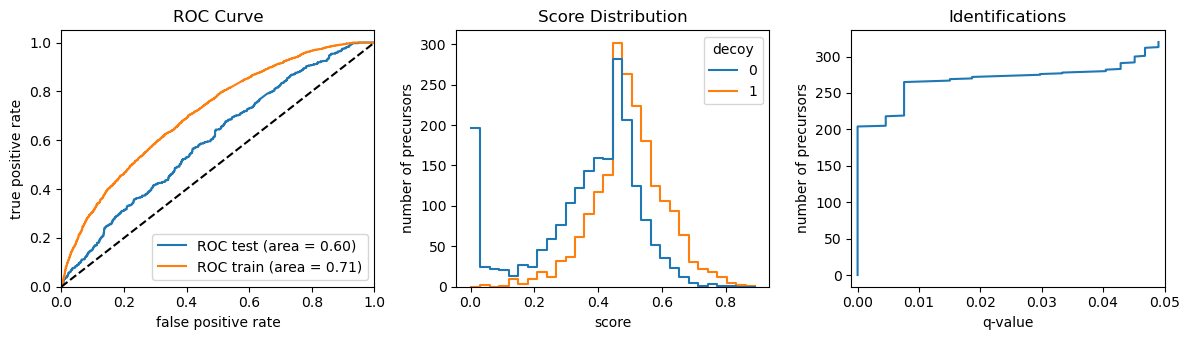

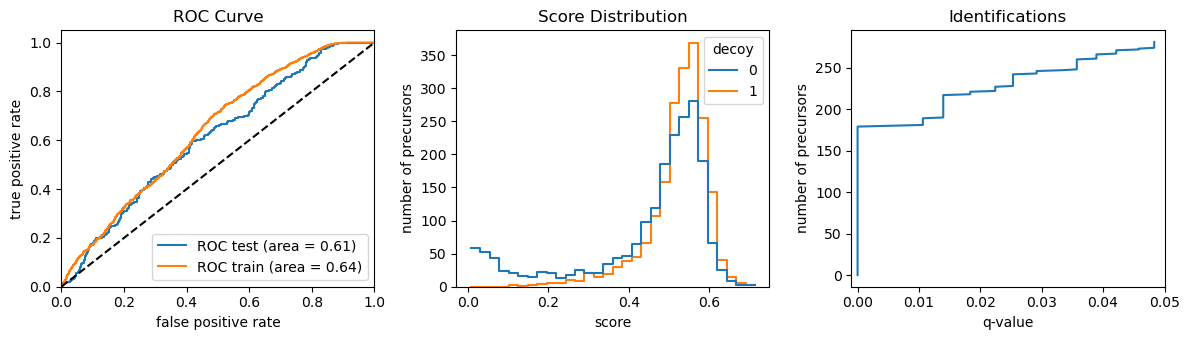

0:02:29.352298  PROGRESS: === checking if recalibration conditions were reached, target 100 precursors ===
0:02:29.352843  PROGRESS: Accumulated precursors: 3,996, 0.01 FDR: 181, 0.001 FDR: 180
0:02:29.353437  INFO: calibration group: precursor, fitting mz estimator 


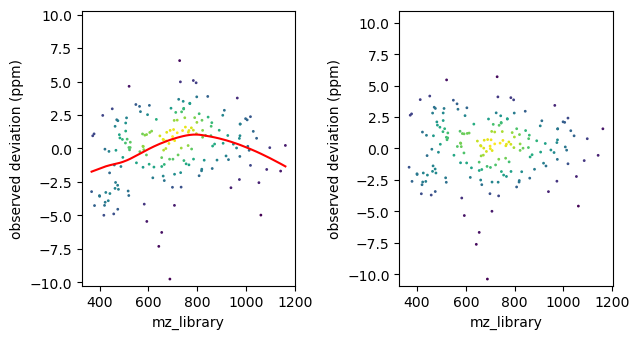

0:02:29.446359  INFO: calibration group: precursor, fitting rt estimator 


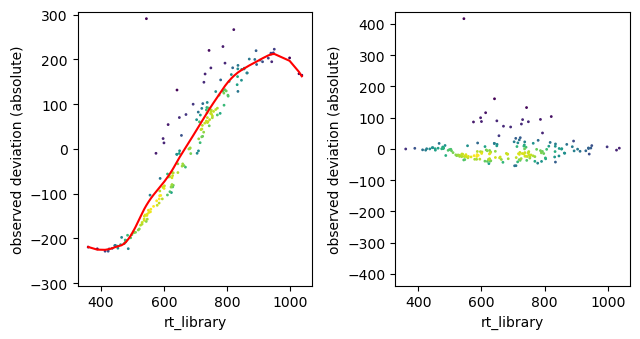

0:02:29.531614  INFO: calibration group: precursor, fitting mobility estimator 


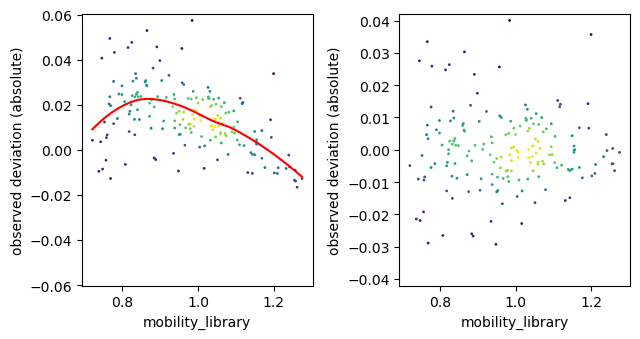

0:02:29.622696  INFO: calibration group: fragment, fitting mz estimator 


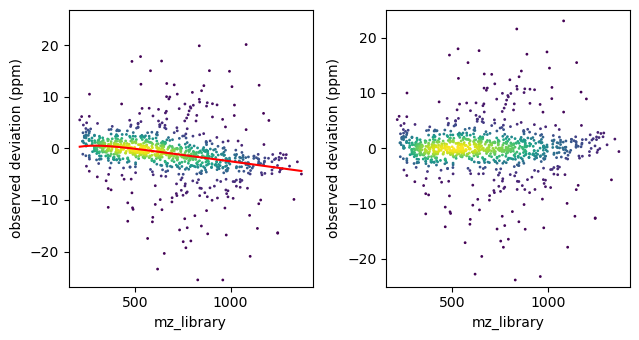

0:02:29.724906  INFO: calibration group: precursor, predicting mz
0:02:29.770518  INFO: calibration group: precursor, predicting rt
0:02:29.903986  INFO: calibration group: precursor, predicting mobility
0:02:29.963222  INFO: calibration group: fragment, predicting mz
0:02:30.502675  PROGRESS: === Epoch 1, step 0, extracting elution groups 0 to 4000 ===
0:02:30.520281  PROGRESS: MS1 error: 15, MS2 error: 15, RT error: 72.14482637639955, Mobility error: 0.04
0:02:30.522053  INFO: Duty cycle consists of 13 frames, 1.39 seconds cycle time
0:02:30.522357  INFO: Duty cycle consists of 928 scans, 0.00065 1/K_0 resolution
0:02:30.522604  INFO: Expected peak length in RT is 8.00 seconds, sigma is 1.44
0:02:30.522854  INFO: Expected peak length in mobility is 0.02 1/K_0, sigma is 7.73
 63%|██████▎   | 2508/4000 [00:11<00:04, 333.22it/s]

In [7]:
plan = Plan(raw_files)
plan.from_spec_lib_base(test_lib)
#plan.run(output_location, keep_decoys=True, fdr=1.0)
for dia_data, precursors_flat, fragments_flat in plan.get_run_data():
    pass

In [59]:
from alphadia.extraction import candidateselection

selection = candidateselection.MS1CentricCandidateSelection(
    dia_data,
    precursors_flat[:30000],
    rt_tolerance=360,
    mz_tolerance=30,
    mobility_tolerance=0.06,
    candidate_count=5,
    thread_count=20,
)

candidates = selection()

0:09:44.644374  INFO: Duty cycle consists of 13 frames, 1.39 seconds cycle time
0:09:44.645982  INFO: Duty cycle consists of 928 scans, 0.00065 1/K_0 resolution
0:09:44.651091  INFO: Expected peak length in RT is 8.00 seconds, sigma is 1.44
0:09:44.652892  INFO: Expected peak length in mobility is 0.02 1/K_0, sigma is 7.73
100%|██████████| 30000/30000 [03:23<00:00, 147.36it/s]
0:13:15.879479  INFO: Extracted candidates for 15054 target precursors (100.00%)
0:13:15.879897  INFO: Extracted candidates for 14946 decoy precursors  (100.00%)


In [60]:
from alphadia.extraction import quadrupole, scoring, features
q = quadrupole.SimpleQuadrupole(dia_data.cycle)

In [61]:
from alphadia.extraction import scoring

extraction = scoring.MS2ExtractionWorkflow(
    dia_data,
    precursors_flat,
    fragments_flat,
    candidates,
    q,
    precursor_mz_tolerance=30,
    fragment_mz_tolerance=30
)

feature_df, fragment_df = extraction()

100%|██████████| 150000/150000 [00:11<00:00, 12701.89it/s]
0:15:23.278148  INFO: Scored 150000 candidates
0:15:23.312880  INFO: 7.11% of targets failed, 9.76% of decoys failed


/Users/georgwallmann/Documents/git/alphadia/alphadia/extraction/scoring.py:131: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum/target_cumsum


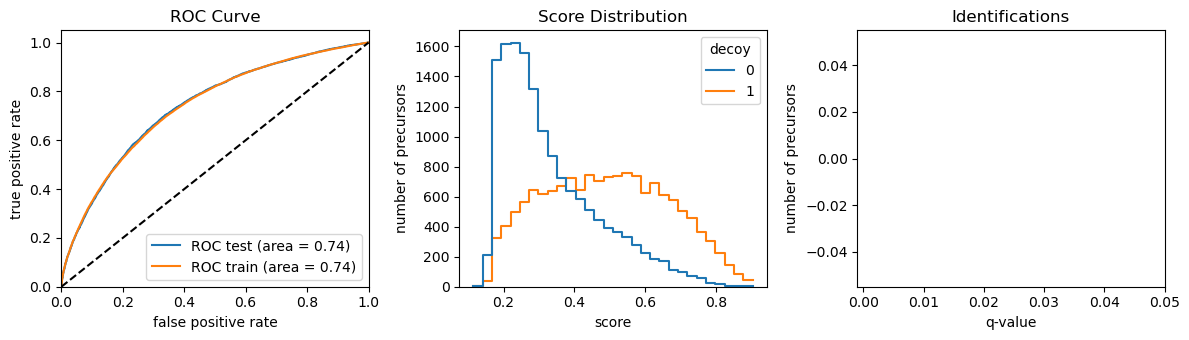

In [62]:
df = scoring.fdr_correction(feature_df)

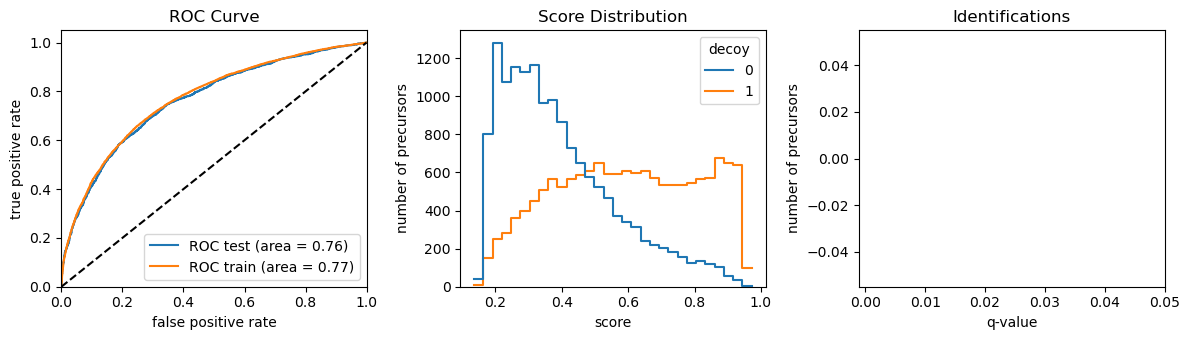

In [63]:
df = scoring.fdr_correction(df)

In [13]:
df.columns

Index(['precursor_idx', 'elution_group_idx', 'charge', 'precursor_mass_error',
       'mz_library', 'mz_observed', 'precursor_isotope_correlation',
       'sum_precursor_intensity', 'n_fragments_matched', 'n_fragments',
       'fraction_fragments', 'intensity_correlation', 'sum_fragment_intensity',
       'mean_fragment_intensity', 'mean_fragment_nonzero', 'n_observations',
       'mean_observation_score', 'var_observation_score', 'fragment_coverage',
       'fragment_scan_correlation', 'fragment_frame_correlation',
       'template_scan_correlation', 'template_frame_correlation',
       'base_width_mobility', 'base_width_rt', 'rt_observed',
       'mobility_observed', 'decoy', 'rt_library', 'rt_error',
       'mobility_library', 'mobility_error', 'proteins', 'proba', 'qval'],
      dtype='object')

In [56]:
feature_cols = ['precursor_mass_error', 
            'precursor_isotope_correlation', 
            'fraction_fragments', 
            'n_fragments',
            'n_fragments_matched',
            'n_observations',
            'intensity_correlation',
            'sum_precursor_intensity',
            'sum_fragment_intensity',
            'mean_fragment_intensity',
            'mean_fragment_nonzero',
            'rt_error',
            'mobility_error',
            'mean_observation_score',
            'var_observation_score',
            'fragment_frame_correlation', 'fragment_scan_correlation', 'template_frame_correlation', 'template_scan_correlation'
            ]

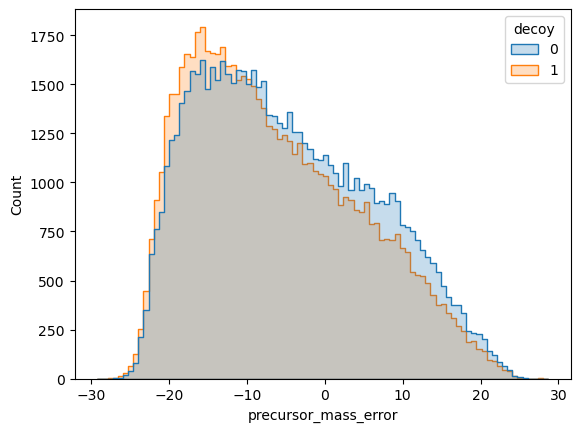

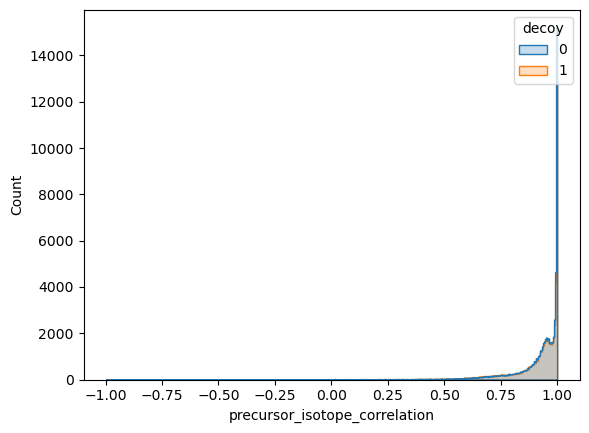

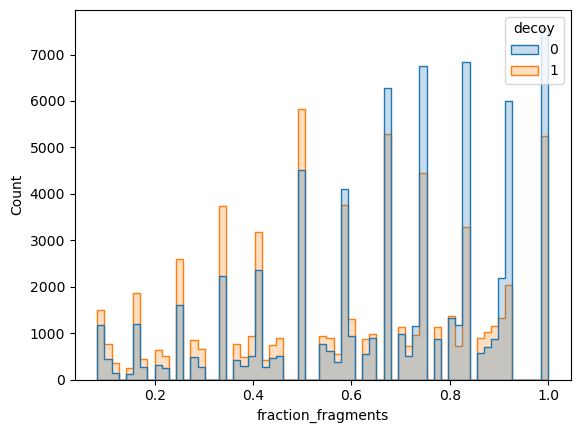

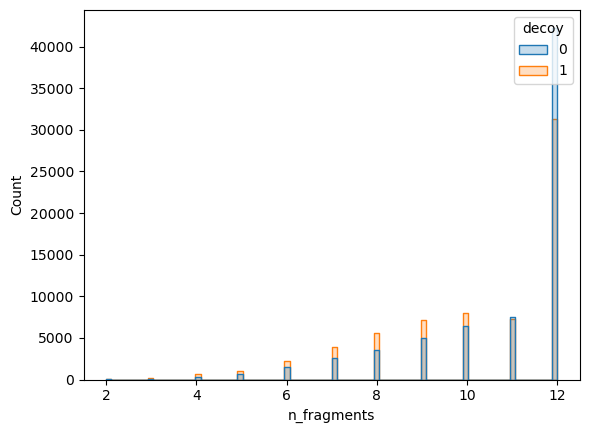

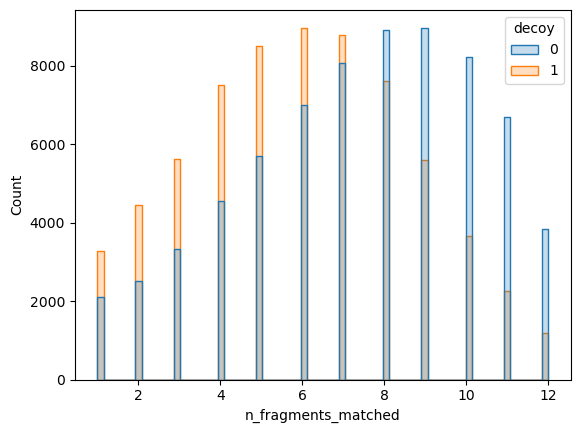

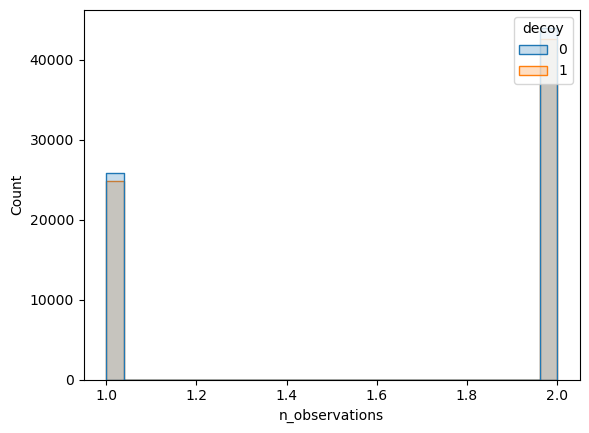

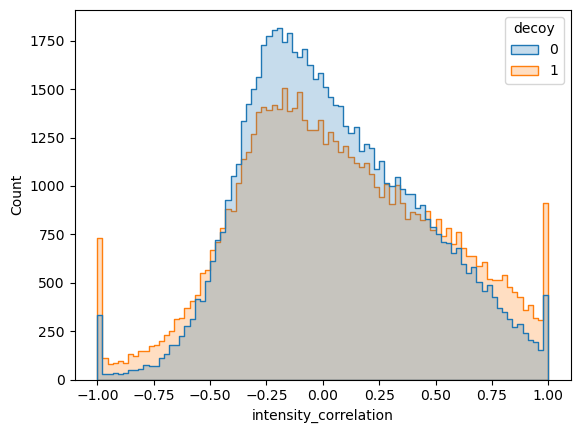

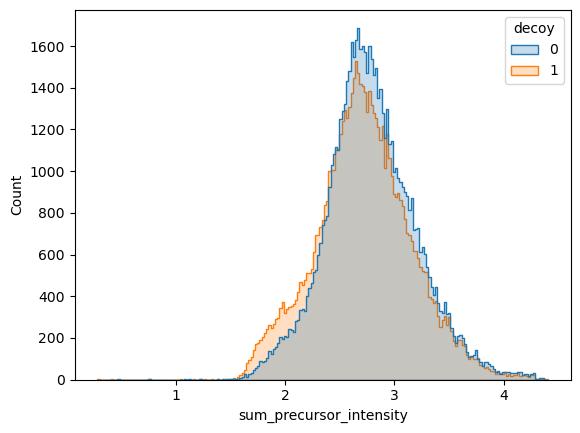

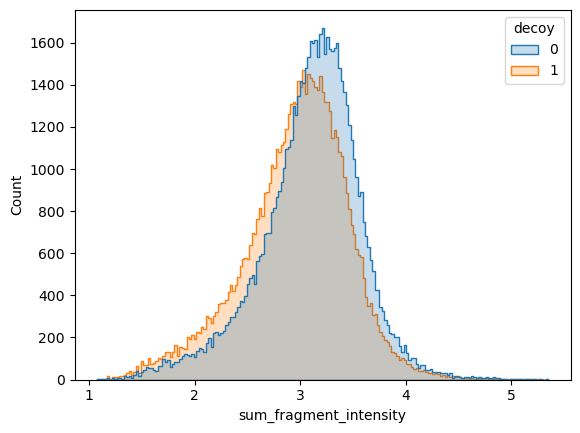

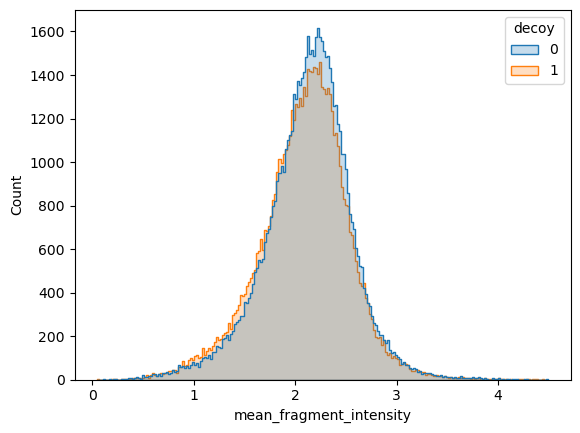

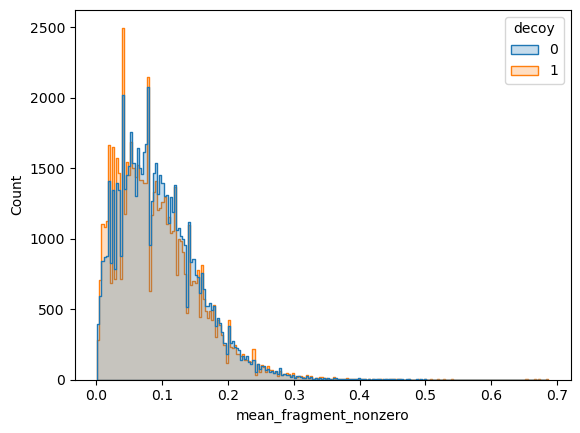

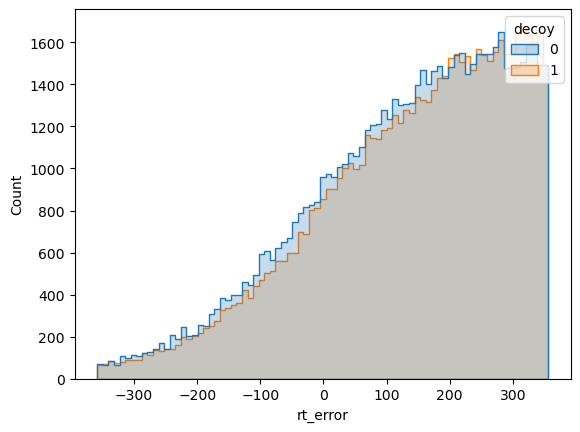

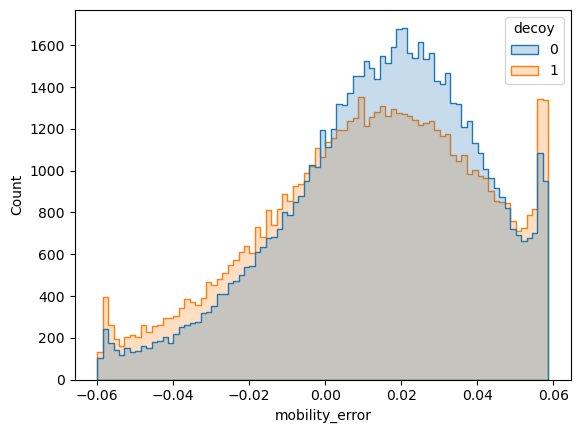

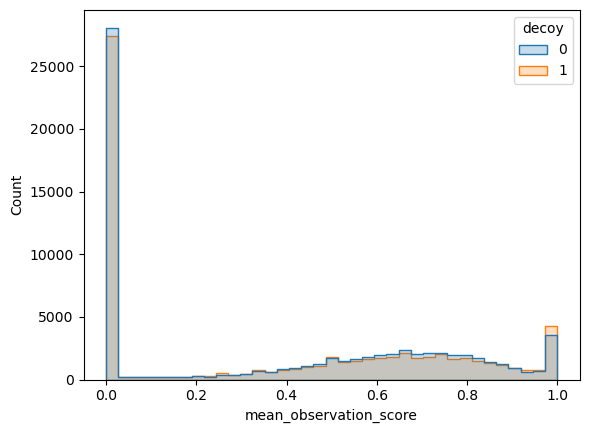

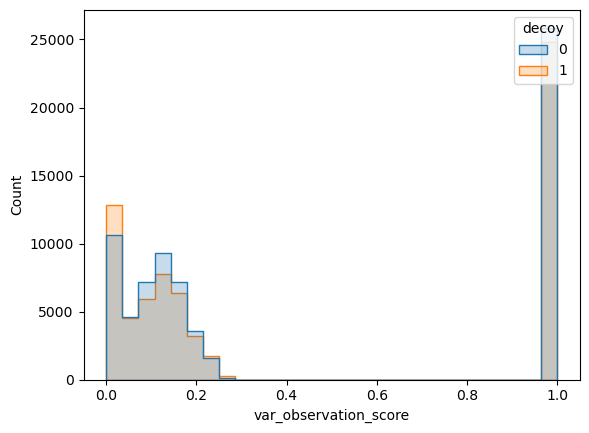

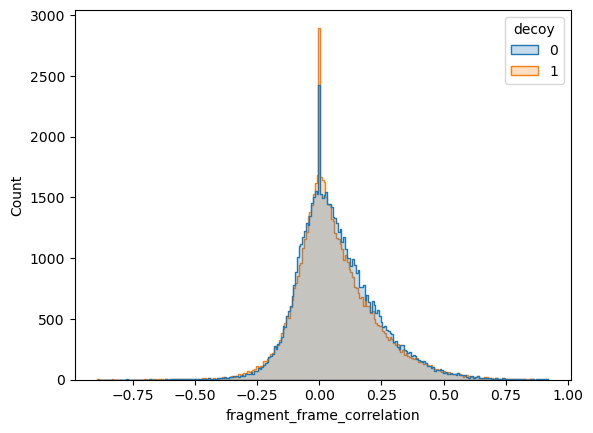

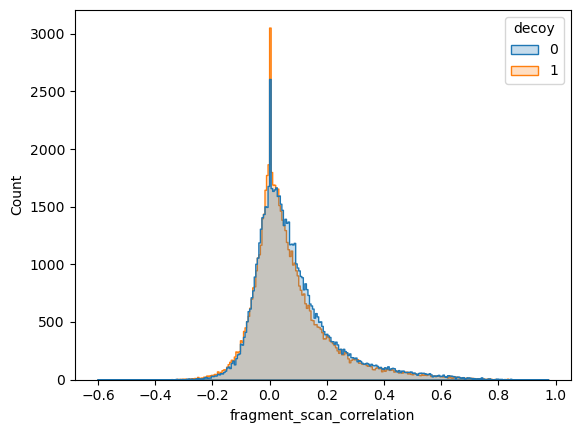

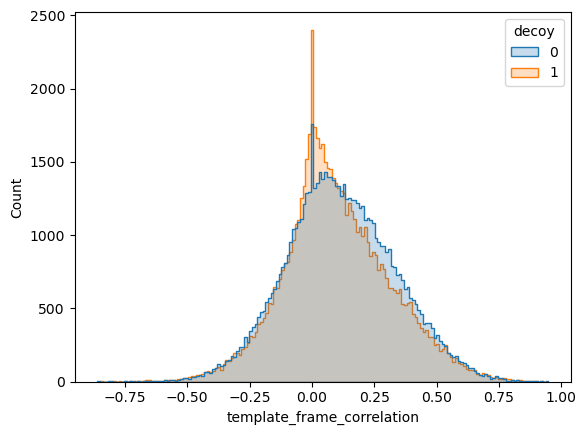

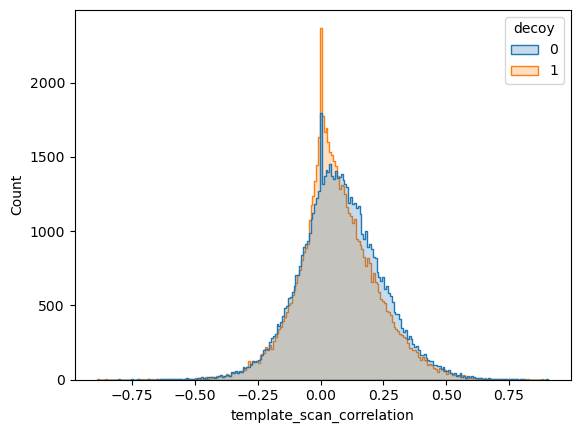

In [64]:
for col in feature_cols:
    sns.histplot(feature_df, x=col, hue='decoy', element='step')
    plt.show()

In [71]:
df_s = df[df['proba'] < 0.15]

In [72]:
from alphadia.extraction import calibration

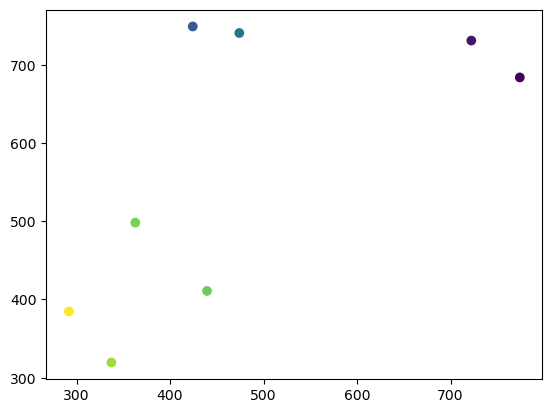

In [73]:
calibration.density_scatter(df_s['rt_library'].values, df_s['rt_observed'].values)

In [ ]:
df = workflow.extraction(keep_decoys=True)

In [ ]:
df[(df['decoy'] == 0)&(df['qval'] <= 0.01)]['proteins'].nunique()

In [ ]:
df_scored = fdr_correction(df)

In [ ]:
df_scored[(df_scored['decoy'] == 0)&(df_scored['qval'] <= 0.01)]['precursor_idx'].nunique()

In [ ]:
from alphadia.extraction import candidateselection

selection = candidateselection.MS1CentricCandidateSelection(
    dia_data,
    precursors_flat,
    rt_tolerance=60,
    mz_tolerance=15,
    mobility_tolerance=0.02,
    candidate_count=10,
    thread_count=20,
    precursor_mz_column='mz_calibrated',
    rt_column='rt_calibrated',
    mobility_column='mobility_calibrated',
    debug=False
)

candidates = selection()

In [ ]:
candidates.head()

In [ ]:
from alphadia.extraction import quadrupole, scoring, features
q = quadrupole.SimpleQuadrupole(dia_data.cycle)

In [ ]:

extraction = scoring.MS2ExtractionWorkflow(
    dia_data,
    precursors_flat,
    fragments_flat,
    candidates,
    q,
    precursor_mz_tolerance=15,
    fragment_mz_tolerance=15,
    precursor_mz_column = 'mz_calibrated',
    fragment_mz_column = 'mz_calibrated',
    rt_column = 'rt_calibrated',
    mobility_column = 'mobility_calibrated',
    debug=False,
)

feature_df, fragment_df = extraction()




In [ ]:
del extraction

In [ ]:
feature_df['precursor_idx'].nunique()   

In [ ]:
feature_df['decoy'].value_counts()

In [ ]:
sns.scatterplot(data=feature_df, x='rt_calibrated', y='mz_calibrated', hue='decoy')

In [ ]:
feature_df[feature_df['decoy'] == 0]['precursor_idx'].nunique()

In [ ]:
df_top = feature_df[feature_df['fragment_coverage'] > 0.4]
idx = df_top.groupby(['precursor_idx'])['mean_fragment_intensity'].idxmax()
df_top = df_top.loc[idx]
df_top[df_top['decoy'] == 0]['precursor_idx'].nunique()

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

feature_columns = ['precursor_mass_error', 
            'precursor_isotope_correlation', 
            'fraction_fragments', 
            'intensity_correlation',
            'sum_precursor_intensity',
            'sum_fragment_intensity',
            'mean_fragment_intensity',
            'mean_fragment_nonzero',
            'rt_error',
            'mobility_error',
            'mean_observation_score',
            'var_observation_score',
            'fragment_frame_correlation', 'fragment_scan_correlation', 'template_frame_correlation', 'template_scan_correlation'
            ]

df_top = df_top.dropna().reset_index(drop=True).copy()

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('GBC', MLPClassifier(hidden_layer_sizes=(50, 25, 5), max_iter=400, alpha=1, learning_rate='adaptive', learning_rate_init=0.001, early_stopping=True, tol=1e-6))
])

X = df_top[feature_columns].values
y = df_top['decoy'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
pipeline.fit(X_train, y_train)


y_test_proba = pipeline.predict_proba(X_test)[:,1]
y_test_pred = np.round(y_test_proba)

y_train_proba = pipeline.predict_proba(X_train)[:,1]
y_train_pred = np.round(y_train_proba)

df_top['proba'] = pipeline.predict_proba(X)[:,1]

df_top = df_top.sort_values(['proba'], ascending=True)
target_values = 1-df_top['decoy'].values
decoy_cumsum = np.cumsum(df_top['decoy'].values)
target_cumsum = np.cumsum(target_values)
fdr_values = decoy_cumsum/target_cumsum

df_top['qval'] = scoring.fdr_to_q_values(fdr_values)

In [ ]:
df_top[(df_top['decoy'] == 0)&(df_top['qval'] < 0.01)]['precursor_idx'].nunique()

In [ ]:
X = feature_df[feature_columns].values
feature_df['proba'] = pipeline.predict_proba(X)[:,1]

In [ ]:
idx = feature_df.groupby(['precursor_idx'])['proba'].idxmin()
rescored = feature_df.loc[idx]

In [ ]:
df_scored = fdr_correction(rescored)

In [ ]:
df_scored[(df_scored['decoy'] == 0)&(df_scored['qval'] <= 0.01)]['precursor_idx'].nunique()

In [ ]:
df_scored[(df_scored['decoy'] == 0)&(df_scored['qval'] > 0.01)&(df_scored['fragment_coverage'] > 0.5)]['precursor_idx'].nunique()

In [ ]:
df_scored['category'] = df_scored['decoy'].map({0: 'target', 1: 'decoy'})

# leave category as target if qval <0.01 change it to target_missed if qval > 0.01
df_scored['category'] = df_scored.apply(lambda x: 'target_missed' if x['category'] == 'target' and x['proba'] > 0.4 else x['category'], axis=1)

In [ ]:
sns.histplot(df_scored, x='rt_error', hue='category', element='step', bins=100)

In [ ]:
sns.scatterplot(df_scored[df_scored['category'] == 'target'], x='rt_library', y='rt_error', s=1, hue='category', hue_order=[ 'target_missed', 'target'])

In [ ]:
feature_df['correlation_score'] = feature_df[['fragment_frame_correlation', 'fragment_scan_correlation', 'template_frame_correlation', 'template_scan_correlation']].apply(np.mean, axis=1)

In [ ]:
df_re = scoring.fdr_correction(feature_df)

In [ ]:
df = df_re[df_re['decoy'] == 0]

df['fragment_coverage'] = np.round(10*df['fragment_coverage'])/10
df['sig'] = df['qval'] < 0.01

In [ ]:
df_re = df_re[df_re['base_width_mobility'] <0.2]

In [ ]:
sns.histplot(df_re, x='base_width_mobility', hue='decoy', stat='count',  bins=100, element='step', )

In [ ]:
sns.scatterplot(data=df, x='fragment_frame_correlation', y='fragment_scan_correlation', hue='decoy', alpha=0.01)

In [ ]:
0.03/1200 * 1e6

In [ ]:
from alphadia.extraction import plotting, quadrupole
@nb.njit
def build_feature(
    dense_fragments,
    template,
    fragments

):

    total_fragment_intensity = np.sum(np.sum(dense_fragments[0], axis=-1), axis=-1)
    total_template_intensity = np.sum(np.sum(template, axis=-1), axis=-1)

    fragment_mask_2d = (total_fragment_intensity > 0).astype(np.int8)
    fragment_mask_1d = np.sum(fragment_mask_2d, axis=-1) > 0
    fragment_mask_2d = fragment_mask_2d * np.expand_dims(fragments.intensity, axis=-1)

    # (n_fragments, n_observations, n_frames)
    fragments_frame_profile = features.or_envelope_2d(features.frame_profile_2d(dense_fragments[0]))
    template_frame_profile = features.or_envelope_2d(features.frame_profile_2d(template))

    # (n_fragments, n_observations, n_scans)
    fragments_scan_profile = features.or_envelope_2d(features.scan_profile_2d(dense_fragments[0]))
    template_scan_profile = features.or_envelope_2d(features.scan_profile_2d(template))

    

    with nb.objmode:
        plotting.plot_fragment_profile(
            template,
            fragments_scan_profile,
            fragments_frame_profile,
            template_frame_profile,
            template_scan_profile,
        )
    

    # (n_fragments, n_observations)
    fragment_scan_correlation, template_scan_correlation = weighted_correlation(
        fragments_scan_profile,
        template_scan_profile,
        fragment_mask_2d,
    )

    
    # (n_fragments, n_observations)
    fragment_frame_correlation, template_frame_correlation = weighted_correlation(
        fragments_frame_profile,
        template_frame_profile,
        fragment_mask_2d,
    )

    observation_importance = quadrupole.calculate_observation_importance(template)
    weights = fragments.intensity / np.sum(fragments.intensity)

    fragment_scan_mean_list = np.sum(fragment_scan_correlation * observation_importance, axis = -1)
    fragment_scan_mean_agg = np.sum(fragment_scan_mean_list * weights)
    print(fragment_scan_mean_agg)

    fragment_frame_mean_list = np.sum(fragment_frame_correlation * observation_importance, axis = -1)
    fragment_frame_mean_agg = np.sum(fragment_frame_mean_list * weights)
    print(fragment_frame_mean_agg)

    template_scan_mean_list = np.sum(template_scan_correlation * observation_importance, axis = -1)
    template_scan_mean_agg = np.sum(template_scan_mean_list * weights)
    print(template_scan_mean_agg)

    template_frame_mean_list = np.sum(template_frame_correlation * observation_importance, axis = -1)
    template_frame_mean_agg = np.sum(template_frame_mean_list * weights)
    print(template_frame_mean_agg)


for candidate in candidate_container[:]:
    if len(candidate.template) > 0:
        res = build_feature(
            candidate.dense_fragments,
            candidate.template,
            candidate.fragments
        )
    

In [ ]:
arr = np.ones((5,5))
mask = np.ones((5,5))
np.fill_diagonal(mask,0)

features.weighted_mean_a1(arr, mask)

In [ ]:
fragment_profile

In [ ]:
dense_fragments = candidate_container[8].dense_fragments[0]
dense_fragments = dense_fragments

In [ ]:
template = candidate_container[8].template

In [ ]:
import numba as nb

@nb.guvectorize([(nb.float64[:,:], nb.float64[:])], '(n, k)->(k)')
def frame_profile(x, res):
    res[:] = np.sum(x, axis=0)

@nb.guvectorize([(nb.float64[:], nb.float64[:])], '(n)->()')
def scan_profile(x, res):
    res[0] = np.sum(x)

@nb.guvectorize([
    (nb.float64[:], nb.float64[:]),
    (nb.float32[:], nb.float32[:]),
    ], '(n)->(n)')
def or_envelope(x, res):
    res[:] = x
    for i in range(1, len(x) - 1):
        if (x[i] < x[i-1]) or (x[i] < x[i+1]):
            res[i] = (x[i-1] + x[i+1]) / 2

@nb.njit
def frame_profile_2d(x):
    return np.sum(x, axis=2)

@nb.njit
def frame_profile_1d(x):
    return np.sum(x, axis=1)

@nb.njit
def scan_profile_2d(x):
    return np.sum(x, axis=3)

@nb.njit
def scan_profile_1d(x):
    return np.sum(x, axis=2)

@nb.njit
def or_envelope_1d(x):
    res = x.copy()
    for a0 in range(x.shape[0]):
        for i in range(1, x.shape[1] - 1):
            if (x[a0, i] < x[a0, i-1]) or (x[a0, i] < x[a0, i+1]):
                res[a0, i] = (x[a0, i-1] + x[a0, i+1]) / 2

@nb.njit
def or_envelope_2d(x):
    res = x.copy()
    for a0  in range(x.shape[0]):
        for a1 in range(x.shape[1]):
            for i in range(1, x.shape[2] - 1):
                if (x[a0, a1, i] < x[a0, a1, i-1]) or (x[a0, a1, i] < x[a0, a1, i+1]):
                    res[a0, a1, i] = (x[a0, a1, i-1] + x[a0, a1, i+1]) / 2
    return res


In [ ]:
fragments_frame_profile = or_envelope_2d(frame_profile_2d(dense_fragments))
fragments_scan_profile = or_envelope_2d(scan_profile_2d(dense_fragments))

template_frame_profile = or_envelope_2d(frame_profile_2d(template))
template_scan_profile = or_envelope_2d(scan_profile_1d(template))

In [ ]:
fragments_scan_profile[:,i_observations].shape

In [ ]:
# (n_fragments, n_observations)
total_fragment_intensity = np.sum(np.sum(dense_fragments, axis=-1), axis=-1)
fragment_mask_2d = (total_fragment_intensity > 0).astype(np.int8)
fragment_mask_2d = fragment_mask_2d * np.expand_dims(candidate_container[8].fragments.intensity, axis=-1)


In [ ]:
fragment_mask_2d

In [ ]:






weighted_correlation(
    fragments_frame_profile,
    template_frame_profile,
    #np.ones_like(fragment_mask_2d),
    fragment_mask_2d,
)
#fragment_mask_2d.shape

In [ ]:
mask_2d = fragment_mask_2d[:,[0]]*fragment_mask_2d[:,0]
np.fill_diagonal(mask_2d, False)

In [ ]:
weighted_mean_a1(
    np.array([[1,2,np.nan],[4,5,6]]),
    np.array([[1,0,0],[1,1,1]])
)

In [ ]:

fragments_frame_profile = or_envelope(frame_profile(dense_fragments))
fragments_scan_profile = or_envelope(scan_profile(dense_fragments))

precursors_frame_profile = or_envelope(frame_profile(template))
precursors_scan_profile = or_envelope(scan_profile(template))

template_scan_profile = or_envelope(scan_profile(template))
template_frame_profile = or_envelope(frame_profile(template))

In [ ]:
fragments_frame_profile[:,0]

In [ ]:
@ nb.njit
def mean_correlation(
    fragment_profile,
    template_profile
):
    correlation = np.corrcoef(fragment_profile, template_profile)
    
    #mean_frame_corr = utils.amean0(correlation[:-1,:-1])-1/len(correlation[:-1,:-1])

    return correlation


In [ ]:
candidate_container[1].fragments.intensity

In [ ]:
plt.imshow(mean_correlation(fragments_frame_profile[:,0], template_frame_profile[0,0]))

In [ ]:
@nb.njit
def weighted_precursor_correlation(
    fragment_profile,
    weights,
):
    n_fragemts = fragment_profile.shape[0]
    n_observations = fragment_profile.shape[1]

    weights = weights / np.sum(weights)

    weighted_correlation = np.zeros((n_fragemts, n_observations))

    for i_observations in range(n_observations):
        correlation = np.corrcoef(fragments_frame_profile[:,i_observations])
        weighted_correlation[:,i_observations] = np.sum(correlation * weights, axis = 1)

    return weighted_correlation

In [ ]:
correlation

In [ ]:
correlation * weight

In [ ]:
weighted_correlation * 

In [ ]:
from alphadia.extraction import utils, plotting
correlations = utils.calculate_correlations(
        template_scan_profile[:,0], 
        fragments_scan_profile[:,0]
)

correlations

In [ ]:
scan_profile = np.sum(dense_fragments, axis = -1)
scan_profile.shape

In [ ]:
a = np.arange(20).reshape(20)
h(a)

In [ ]:
template_scan_profile = np.sum(template, axis=-1)
fragment_scan_profile = np.sum(dense_fragments, axis=-1)

In [ ]:
fragment_scan_profile.shape

In [ ]:

template_scan_profile.shape

In [ ]:
print(n_observations)

In [ ]:
feature_df['precursor_mass_error'] = np.abs(feature_df['precursor_mass_error'])
feature_df['rt_error'] = np.abs(feature_df['rt_error'])

In [ ]:
df = scoring.fdr_correction(feature_df)
df = scoring.fdr_correction(df)

In [ ]:
df_sig = df[df['qval'] <= 0.01]


In [ ]:
df.columns

In [ ]:
missing_ids = np.setdiff1d(candidates[candidates['decoy'] == 0]['precursor_idx'].unique(), ids)

In [ ]:
missing_ids

In [ ]:
from tqdm import tqdm
candidate_container = cc

fragment_collection = {'precursor_idx': []}
feature_collection = []

# initialize fragment collection with empty lists
for key in candidate_container[0].fragment_features.keys():
    fragment_collection[key] = []

for i, c in enumerate(tqdm(candidate_container)):

    n = 0
    for key, item in c.fragment_features.items():
        
        fragment_collection[key].append(item)
        n = len(item)
        
    fragment_collection['precursor_idx'].append(np.repeat(c.precursor_idx[0], n))
    

    if i > 10:
        break
    #feature_collection.append(self._collect_candidate(c))

for key, item in fragment_collection.items():
    fragment_collection[key] = np.concatenate(item)

In [ ]:
cc[0].precursor_idx[0]

In [ ]:
for key, item in fragment_collection.items():
    print(key, item.shape)

In [ ]:
collection_dict = {}

for key in cc[0].fragment_features.keys():
    collection_dict[key] = []

for c in cc:
    for key, item in c.fragment_features.items():
        collection_dict[key].append(item)

for key, item in cc[0].fragment_features.items():
    collection_dict[key] = np.concatenate(collection_dict[key])

df = pd.DataFrame(collection_dict)

In [ ]:
df

In [ ]:
import numba as nb

@nb.njit
def cosine_similarity_1d(template_intensity, fragments_intensity):

    fragment_norm = np.sqrt(np.sum(np.power(fragments_intensity,2),axis=-1))
    template_norm = np.sqrt(np.sum(np.power(template_intensity,2),axis=-1))

    div = (fragment_norm * template_norm) + 0.0001

    return np.sum(fragments_intensity * template_intensity,axis=-1) / div

In [ ]:
template_intensity = np.sum(np.sum(cc[0].template, axis=-1), axis=-1)
fragments_intensity = np.sum(np.sum(cc[0].dense_fragments[0], axis=-1), axis=-1)

fragment_mask_2d = fragments_intensity > 0
fragment_mask_1d = np.sum(fragment_mask_2d, axis=-1) > 0

print(fragment_mask_1d)

score = cosine_similarity_1d(template_intensity, fragments_intensity[fragment_mask_1d])

In [ ]:
score

In [ ]:
#template_dist = template_dist / np.sum(template_dist, axis=-1)
template_dist


In [ ]:

#fragments_dist = fragments_dist/np.sum(fragments_dist, axis=-1, keepdims=True)

fragments_dist

In [ ]:
fragments_flat[['mz_library']].values.astype(np.float32)

In [ ]:
dot = 
dot / 

In [ ]:
@nb.njit
def cosine_similarity_int(a, b):
    div = np.sqrt(np.sum(a))*np.sqrt(np.sum(b))
    if div == 0:
        return 0
    return np.sum((a*b))/div

In [ ]:
df.sort_values(by='base_width_mobility')[['base_width_mobility', 'precursor_idx','decoy']]

In [ ]:
df.sort_values('base_width_mobility')[['precursor_idx','elution_group_idx','base_width_mobility','decoy']].head(10)

In [ ]:
from alphadia.extraction import scoring
df = scoring.fdr_correction(df)


df['significant'] = df['qval'] <= 0.01

In [ ]:
df['mean_observation_score']

In [ ]:
df = df[df['n_observations'] == 1]
df[['mean_observation_score','precursor_idx','decoy']]

In [ ]:
df.columns

In [ ]:
sns.histplot(df, x='rt_error',hue='decoy', bins=100)

In [ ]:
sns.violinplot(data=df, y='mean_observation_score', x='n_observations', hue='decoy', split=True,bw=.15)

In [ ]:
sns.scatterplot(data=df, x='mean_observation_score', y='var_observation_score', hue='decoy')

In [ ]:
df_sig = df[df['qval'] < 0.05]
utils.density_scatter(df_sig['rt_library'].values, df_sig['rt_error'].values )

In [ ]:
import numba as nb



expand_cycle(dia_data.cycle,2)